In [10]:
# Intro: one-hot encoding of text using Keras
import keras

Using TensorFlow backend.


#### One-hot word encoding

In [11]:
## Word-level
from keras.preprocessing.text import Tokenizer
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Create a tokenizer that takes the first 1,000 common words into account
tokenizer = Tokenizer(num_words=1000)

In [15]:
# Now fit the tokenizer on the data
tokenizer.fit_on_texts(samples)
# This builds the word index, which can be also saved as a variable as follows
word_index = tokenizer.word_index
print(word_index)

{'sat': 3, 'mat': 5, 'my': 8, 'dog': 6, 'homework': 9, 'the': 1, 'ate': 7, 'on': 4, 'cat': 2}


In [18]:
# Now we can used the tokenizer to create a sequence of integers
sequences = tokenizer.texts_to_sequences(samples)
print(sequences)

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]


In [19]:
# And we can also use the tokenizer to do the one-hot encoding directly.
one_hot = tokenizer.texts_to_matrix(samples, mode='binary')
print(one_hot)

[[ 0.  1.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]]


#### One-hot word encoding with hashing trick

In [22]:
# In this case we hash words into a vector of fixed size
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
dimensionality = 1000
max_length = 10
results = np.zeros((len(samples), max_length, dimensionality))

In [29]:
# Each word is hashed into a random integer index between 0 and 1,000
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

#### Word embeddings

Word embeddings are low-dimensional floating-point vectors which are learnt from data. Typical dimensions when dealing with large vocabularies is 256, 512 or 1,024.

There are two ways to obtain embeddings: 
- Learn word embeddings jointly with the main task you care about
- Use pre-trained word embeddings, we will explore both

##### Learning word embeddings
The geometric relationships between word vectors should reflect the semantic relationships between these words. 
In other words we want to map human language into a geometric space.
Because the mapping can be different depending on the context, it makes sense to learn the embedding for each specific task. This is done by learning the weights of an Embedding layer.

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)

The embedding layer can be also seen as a dictionary that maps integer indices (which stand for specific words) to dense vectors.
The Embedding layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers.
The Embedding layer returns a 3D floating-point tensor of shape `(samples, sequence_ length, embedding_dimensionality)`. Such a 3D tensor can then be processed by an RNN layer or a 1D convolution layer

In [36]:
# Let's now learn an embedding layer in the context of doing a sentiment analysis of IMDB reviews
# First we load and prepare the data
from keras.datasets import imdb
from keras import preprocessing
# Set the maximum number of features (the dimensionality of the embedding layer)
max_features = 10000
# Now set the maximum number of words to consider (the lenght of the sequence)
maxlen = 20
# Load the data
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=max_features)
# Then turn the lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [37]:
# Now let's set up and train the network using the embedding layer
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to the Embedding layer so we can later flatten the embedded inputs.
model.add(Embedding(10000, 8, input_length=maxlen))
# We then flatten the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())
# And finally a binary classifier
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 207us/step - loss: 0.6701 - acc: 0.6223 - val_loss: 0.6242 - val_acc: 0.7072
Epoch 2/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.5491 - acc: 0.7500 - val_loss: 0.5294 - val_acc: 0.7412
Epoch 3/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.4634 - acc: 0.7876 - val_loss: 0.5021 - val_acc: 0.7548
Epoch 4/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.4185 - acc: 0.8138 - val_loss: 0.4968 - val_acc: 0.7576
Epoch 5/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.3876 - acc: 0.8307 - val_loss: 0.5001 - val_acc: 0.7586
Epoch 6/10
20000/20000 [==============================] - 2s 114us/step - loss: 0.3620 - acc: 0.8427 - val_loss: 0.5051 - val_acc: 0.7572
Epoch 7/10
20000/20000 [==============================] - 2s 112us/step - loss: 0.3392 - acc: 0.8558 - val_loss: 0.5114 - v

The accuracy is ~75%, which is good because it's a simple network which only takes into account the first 20 words of each review. Moreover, such a model doesn't take the order and the relationship of words into account. For that we would need to use a 1D convnet or an RNN. We'll explore these later on.

##### Using pre-trained embeddings

Loading a pre-trained embedding can be done when we don't have enough data to learn our own embedding. There are various precomputed databases of word embeddings that can be downloaded and used in a Keras Embedding layer. Word2Vec is one of them. Another popular one is GloVe.
The example below uses GloVe (but the same approach can be used for Word2Vec).

In [62]:
# Let's first load the raw imdb data and process the labels
import os

imdb_dir = '/home/ec2-user/datasets/imdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [63]:
# Now we can tokenize the data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
# We cut reviews at 100 words
maxlen = 100
# We train on 200 samples...
training_samples = 200
# ...and validate on 10000 samples
validation_samples = 10000
# We consider only the top 10000 words in the Tokenizing datasets
max_words = 10000
# Set up the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [64]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [65]:
# We now need to make the sequences all of the same length, padding when necessary
data = pad_sequences(sequences, maxlen=maxlen)

In [66]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [67]:
# We now split the data into training and test set. We shuffle the data first because the data is ordered
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [68]:
# Now let's load up the GloVe embeddings
glove_dir = '/home/ec2-user/datasets/word_embeddings/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Next, we’ll build an embedding matrix that we can load into an Embedding layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry i contains the `embedding_dim`-dimensional vector for the word of index i in the reference word index (built during tokenization). Note that index 0 isn’t supposed to stand for any word or token—it’s a placeholder.

In [77]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [78]:
# Now let's define the model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [80]:
# And now we can load the embeddings matrix into the embedding layer.
model.layers[0].set_weights([embedding_matrix])
# We also freeze the weights
model.layers[0].trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [81]:
# Let's now train, evaluate and save the model
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('/home/ec2-user/models/imdb/pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 2.2841 - acc: 0.5000 - val_loss: 0.7208 - val_acc: 0.5231
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5755 - acc: 0.6450 - val_loss: 0.9998 - val_acc: 0.5026
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3532 - acc: 0.8850 - val_loss: 0.8355 - val_acc: 0.5179
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3546 - acc: 0.8350 - val_loss: 0.6916 - val_acc: 0.5744
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1921 - acc: 0.9700 - val_loss: 1.1691 - val_acc: 0.4997
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2005 - acc: 0.9350 - val_loss: 0.7264 - val_acc: 0.5742
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0842 - acc: 0.9950 - val_loss: 0.8951 - val_acc: 0.5202
Epoch 8/10
200/200 [========

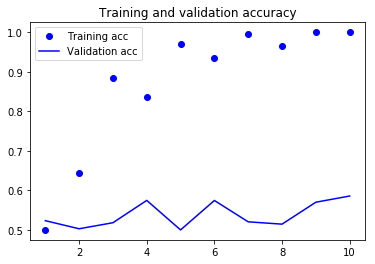

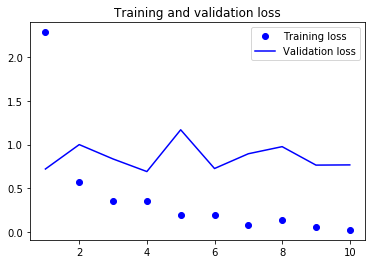

In [82]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The model starts to overfit pretty quickly, which is to be expected given that there are so few training sample.

We can also re-run the model without loading the pre-trained embeddings. This is generally more powerful as the embeddings will be specific to the problem at hand, but in the case we only have 200 training samples, so the performance won't be very good.

In [83]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6937 - acc: 0.5450 - val_loss: 0.6920 - val_acc: 0.5197
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5052 - a

In this case the performance of trained embedding is basically the same as that of the learned embedding. If we were to increase the training sample, this would increase. Let's try

In [86]:
new_training_samples = 1000
x_train_more = data[:new_training_samples]
y_train_more = labels[:new_training_samples]
x_val_more = data[new_training_samples: new_training_samples + validation_samples]
y_val_more = labels[new_training_samples: new_training_samples + validation_samples]

In [87]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train_more, y_train_more,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val_more, y_val_more))

Train on 1000 samples, validate on 10000 samples
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6911 - acc: 0.5320 - val_loss: 0.6909 - val_acc: 0.5072
Epoch 2/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4523 - acc: 0.9500 - val_loss: 0.6681 - val_acc: 0.5933
Epoch 3/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1342 - acc: 0.9950 - val_loss: 0.6937 - val_acc: 0.5927
Epoch 4/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0252 - acc: 1.0000 - val_loss: 0.6868 - val_acc: 0.6211
Epoch 5/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.7124 - val_acc: 0.6267
Epoch 6/10
1000/1000 [==============================] - 1s 1ms/step - loss: 7.4301e-04 - acc: 1.0000 - val_loss: 0.7782 - val_acc: 0.6298
Epoch 7/10
1000/1000 [==============================] - 1s 1ms/step - loss: 1.3273e-04 - acc: 1.0000 - val_loss: 0.8969 - val_acc: 0.6222
Epoch

As we can see, the validation accuracy increases to ~64%, thanks to using more training samples.
Finally, let’s evaluate the model on the test data. First, we need to tokenize the test data.

In [89]:
imdb_dir = '/home/ec2-user/datasets/imdb/aclImdb'
train_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [90]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [91]:
model.load_weights('/home/ec2-user/models/imdb/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 94us/step


[0.76388788042068478, 0.58016000000000001]

We get a pretty low accuracy of ~58%, due to the fact that the saved model only had a handful of training data